In [ ]:
#实际模型

In [1]:
import os
import sys
import random
import pandas as pd
import numpy as np
#import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
## Seeding 

def setup_seed(seed):
    random.seed(seed)  # 为python设置随机种子
    np.random.seed(seed)  # 为numpy设置随机种子
    tf.random.set_seed(seed)  # tf cpu fix seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first

setup_seed(2020)


seed = 2020
random.seed = 2020
np.random.seed = 2020
tf.seed = 2020
tf.random.set_seed(2020)


In [2]:
from keras.layers import add, ConvLSTM2D, Reshape, Dense, AveragePooling2D, Input, Conv2DTranspose, TimeDistributed, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import add, Reshape, Dense, Input, TimeDistributed, Dropout, Activation, LSTM, Conv1D, Cropping1D,GRU
from keras.layers import MaxPooling1D, UpSampling1D, Cropping1D, SpatialDropout1D, Bidirectional, BatchNormalization 
from keras.models import Model, Sequential
import keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras import metrics
from keras.optimizers import Adam
import matplotlib

# 训练集

In [3]:
#时域模态信息

import scipy.io as scio
import pandas as pd

#1 input
feature1tr = r'\训练集\时域\ACC_EW.mat'
data1tr = scio.loadmat(feature1tr)
AAtr=data1tr['ACC_EW']
Atr=AAtr[:,0:300]

feature2tr = r'\训练集\时域\ACC_NS.mat'
data2tr = scio.loadmat(feature2tr)
BBtr=data2tr['ACC_NS']
Btr=BBtr[:,0:300]

feature3tr = r'\训练集\时域\ACC_UD.mat'
data3tr = scio.loadmat(feature3tr)
CCtr=data3tr['ACC_UD']
Ctr=CCtr[:,0:300]


raw_data1tr=np.hstack((Atr,Btr))
x_datatr=np.hstack((raw_data1tr,Ctr))

print(x_datatr.shape)



(5676, 900)


In [4]:
#频域模态信息

import scipy.io as scio
import pandas as pd

#input
feature1str = r'\训练集\频谱\3s\spec_EW_seismic.mat'
data1str = scio.loadmat(feature1str)
AAstr=data1str['spec_EW_seismic']
Astr=AAstr[:,0:150]

feature2str = r'\训练集\频谱\3s\spec_NS_seismic.mat'
data2str = scio.loadmat(feature2str)
BBstr=data2str['spec_NS_seismic']
Bstr=BBstr[:,0:150]

feature3str = r'\训练集\频谱\3s\spec_UD_seismic.mat'
data3str = scio.loadmat(feature3str)
CCstr=data3str['spec_UD_seismic']
Cstr=CCstr[:,0:150]



raw_data1s=np.hstack((Astr,Bstr))
x_datastr=np.hstack((raw_data1s,Cstr))

print(x_datastr.shape)



(5676, 450)


In [5]:
#特征模态信息

import scipy.io as scio
import pandas as pd

labeltr = pd.read_csv(open(r'\训练集\文本信息\3s\训练文本特征.csv',encoding='UTF-8'))
y_datatr=labeltr.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12]].values  #特征嵌入
print(y_datatr[0])
print(y_datatr.shape)





[-2.44590229 -1.05275547 -0.37217339 -5.12400814 -2.33826046  1.39035392
  1.62555399  1.01908469 -0.37389845 -2.19619784 -0.3752915  -3.89165263
  4.0161749 ]
(5676, 13)


In [6]:
train_y=y_datatr[:,[12]]
train_feature=y_datatr[:,[0,1,2,3,4,5,6,7,8,9,10,11]]
print(train_y.shape)
print(train_y[0])

print(train_feature.shape)
print(train_feature[0])

(5676, 1)
[4.0161749]
(5676, 12)
[-2.44590229 -1.05275547 -0.37217339 -5.12400814 -2.33826046  1.39035392
  1.62555399  1.01908469 -0.37389845 -2.19619784 -0.3752915  -3.89165263]


In [7]:
#时域模态 训练
train_xt=[]
for i in range(len(x_datatr)):
    train_xt.append(np.array(x_datatr[i].reshape(3,1,300)).T)

In [8]:
#频域模态 训练
train_xs=[]
for i in range(len(x_datastr)):
    train_xs.append(np.array(x_datastr[i].reshape(3,1,150)).T)

In [9]:
train_xt=np.array(train_xt)

train_xs=np.array(train_xs)

In [10]:
#3#  ##Reshaping
#时域
train_xt = np.reshape(train_xt, (train_xt.shape[0], 300, 3))
print("0",train_xt.shape[0])
print("1",train_xt.shape[1])
print(train_xt.shape)

#频域
train_xs = np.reshape(train_xs, (train_xs.shape[0], 150, 3))
print("0",train_xs.shape[0])
print("1",train_xs.shape[1])
print(train_xs.shape)

0 5676
1 300
(5676, 300, 3)
0 5676
1 150
(5676, 150, 3)


(150,)


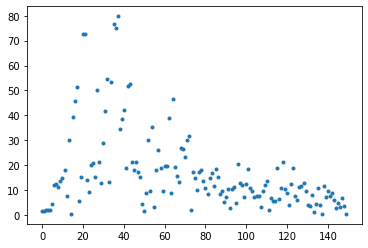

In [11]:
import matplotlib.pyplot as plt  # 导入图形展示库
plt.plot(train_xs[0,:,0],'.')
print(train_xs[0,:,0].shape)
#print(train_xs[0,:,0].shape)

# 测试集

In [12]:
#时域模态信息

import scipy.io as scio
import pandas as pd

#1 input
feature1te = r'\测试集\时域\ACC_EW.mat'
data1te = scio.loadmat(feature1te)
AAte=data1te['ACC_EW']
Ate=AAte[:,0:300]

feature2te = r'\测试集\时域\ACC_NS.mat'
data2te = scio.loadmat(feature2te)
BBte=data2te['ACC_NS']
Bte=BBte[:,0:300]

feature3te = r'\测试集\时域\ACC_UD.mat'
data3te = scio.loadmat(feature3te)
CCte=data3te['ACC_UD']
Cte=CCte[:,0:300]


raw_data1te=np.hstack((Ate,Bte))
x_datate=np.hstack((raw_data1te,Cte))

print(x_datate.shape)



(2392, 900)


In [13]:
#频域模态信息

import scipy.io as scio
import pandas as pd

#input
feature1ste = r'\测试集\频谱\3s\spec_EW_seismic.mat'
data1ste = scio.loadmat(feature1ste)
AAste=data1ste['spec_EW_seismic']
Aste=AAste[:,0:150]

feature2ste = r'\测试集\频谱\3s\spec_NS_seismic.mat'
data2ste = scio.loadmat(feature2ste)
BBste=data2ste['spec_NS_seismic']
Bste=BBste[:,0:150]

feature3ste = r'\测试集\频谱\3s\spec_UD_seismic.mat'
data3ste = scio.loadmat(feature3ste)
CCste=data3ste['spec_UD_seismic']
Cste=CCste[:,0:150]




raw_data1ste=np.hstack((Aste,Bste))
x_dataste=np.hstack((raw_data1ste,Cste))


print(x_dataste.shape)



(2392, 450)


In [14]:
#特征模态信息

import scipy.io as scio
import pandas as pd

labelte = pd.read_csv(open(r'\测试集\文本信息\3s\测试文本特征.csv',encoding='UTF-8'))
y_datate=labelte.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12]].values  #特征嵌入
print(y_datate[0])
print(y_datate.shape)


[-2.71412519 -1.14430233 -0.98776559 -5.4456713  -2.68815677  1.1575801
  1.19418827  0.82440256 -0.5149543  -3.40708966 -0.80705893 -4.80028983
  2.26057671]
(2392, 13)


In [15]:
test_y=y_datate[:,[12]]
test_feature=y_datate[:,[0,1,2,3,4,5,6,7,8,9,10,11]]
print(test_y.shape)
print(test_y[0])

print(test_feature.shape)
print(test_feature[0])

(2392, 1)
[2.26057671]
(2392, 12)
[-2.71412519 -1.14430233 -0.98776559 -5.4456713  -2.68815677  1.1575801
  1.19418827  0.82440256 -0.5149543  -3.40708966 -0.80705893 -4.80028983]


In [16]:
#时域模态 测试
test_xt=[]
for i in range(len(x_datate)):
    test_xt.append(np.array(x_datate[i].reshape(3,1,300)).T)

In [17]:
#频域模态 测试
test_xs=[]
for i in range(len(x_dataste)):
    test_xs.append(np.array(x_dataste[i].reshape(3,1,150)).T)

In [18]:
test_xt=np.array(test_xt)

test_xs=np.array(test_xs)

In [19]:
#3#  ##Reshaping
#时域
test_xt = np.reshape(test_xt, (test_xt.shape[0], 300, 3))
print("0",test_xt.shape[0])
print("1",test_xt.shape[1])
print(test_xt.shape)

#频域
test_xs = np.reshape(test_xs, (test_xs.shape[0], 150, 3))
print("0",test_xs.shape[0])
print("1",test_xs.shape[1])
print(test_xs.shape)

0 2392
1 300
(2392, 300, 3)
0 2392
1 150
(2392, 150, 3)


(150,)


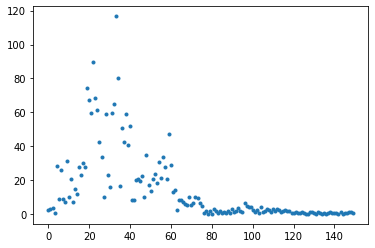

In [20]:
#import matplotlib.pyplot as plt  # 导入图形展示库
plt.plot(test_xs[10,:,0],'.')
print(test_xs[0,:,0].shape)
#print(test_xs[0,1,:,0].shape)

In [21]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers,Sequential,losses,optimizers,datasets

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K


from keras import backend as K
from keras.engine.topology import Layer
class GlobalAttentionLayer(layers.Layer):
    def __init__(self, units, **kwargs):
        super(GlobalAttentionLayer, self).__init__(**kwargs)
        self.dense1 = layers.Dense(units, activation='tanh')
        self.dense2 = layers.Dense(1, activation='softmax')  # 注意：这里的softmax实际上是为了归一化，但后续会处理
        self.mul = layers.Multiply()
 
    def call(self, inputs, mask=None):
        attention_scores = self.dense1(inputs)
        # 为了在序列长度维度上应用softmax，我们直接对scores应用softmax
        # 注意：这里的softmax是为了生成权重，但因为我们只需要加权和，所以实际上不需要显式地归一化到1（但这样做也无妨）
        attention_weights = tf.nn.softmax(self.dense2(attention_scores), axis=1)
        
        # 将注意力权重与输入序列相乘并求和得到加权和
        weighted_sum = self.mul([inputs, tf.expand_dims(attention_weights, -1)])
        weighted_sum = tf.reduce_sum(weighted_sum, axis=1)
        
        return weighted_sum

In [22]:
seed=50
drop_rate = 0.2
def Timedomain(x):

    x = tf.keras.layers.Conv1D(256, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2,strides=2,

    x = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2,strides=2,
    
    x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2,strides=2,
    
    

    x = tf.keras.layers.Dropout(rate=0.2)(x) #0.458
    


    
    x = tf.keras.layers.Bidirectional(GRU(256,use_bias=True, return_sequences = False,activation='tanh',\
                                          kernel_initializer=keras.initializers.he_normal(seed=2020),\
                                          bias_initializer=keras.initializers.he_normal(seed=2020),recurrent_activation='sigmoid',\
                                          reset_after = True,recurrent_dropout=0,unroll=False,\
                                          recurrent_initializer=keras.initializers.he_normal(seed=2020)))(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x) #0.458   
    
    return x

def Specdomain(x):
    
    x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2
      
    
    
    
    x = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same',\
                            kernel_initializer=keras.initializers.he_normal(seed=2020),\
                            bias_initializer=keras.initializers.he_normal(seed=2020))(x)  
    x = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(x) # 高宽各减半的池化层  pool_size=2
    x = tf.keras.layers.Dropout(rate=0.2)(x) #0.458
      
    


       
    x = tf.keras.layers.Bidirectional(GRU(64,use_bias=True, return_sequences = True,activation='tanh',\
                                          kernel_initializer=keras.initializers.he_normal(seed=2020),\
                                          bias_initializer=keras.initializers.he_normal(seed=2020),recurrent_activation='sigmoid',\
                                          reset_after = True,recurrent_dropout=0,unroll=False,\
                                          recurrent_initializer=keras.initializers.he_normal(seed=2020)))(x)    

    x = tf.keras.layers.Bidirectional(GRU(32,use_bias=True, return_sequences = False,activation='tanh',\
                                          kernel_initializer=keras.initializers.he_normal(seed=2020),\
                                          bias_initializer=keras.initializers.he_normal(seed=2020),recurrent_activation='sigmoid',\
                                          reset_after = True,recurrent_dropout=0,unroll=False,\
                                          recurrent_initializer=keras.initializers.he_normal(seed=2020)))(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x) #0.458
    
    return x


def Features(x):
    x = Dense(128, activation='relu')(x)#relu
    x = Dense(128, activation='relu')(x)#relu


    
    return x
    


In [23]:
seed=50
drop_rate = 0.2
from tensorflow import keras
from keras.models import Model
def CRmodel():
    inpt1 = Input(shape=(300, 3), name='input_layer1') #时域
    inpt2 = Input(shape=(150, 3), name='input_layer2') #频域
    

    
    x1 = Timedomain(inpt1)
    
    x2 = Specdomain(inpt2)

    

    inpt3 = tf.keras.layers.Input(shape=(12,1))   #加入特征模态
    x3 = Features(inpt3)
    x3 = tf.keras.layers.Flatten()(x3) # 打平层，方便全连接层处理
    #x3 = Features(inpt3)

    concat = tf.keras.layers.Concatenate()([x1, x2, x3])
    concat = GlobalAttentionLayer(256)(concat)##256
    

    e = Dense(32, activation='relu')(concat)#relu
    
    oupts = Dense(1)(e)

#    
    model=Model(inputs=[inpt1,inpt2,inpt3], outputs=oupts)
    #model=Model(inputs=inpt2, outputs=z)
    return model

In [24]:
#优点：由于DNN几乎可以拟合任何函数，所以DNN的非线性拟合能力非常强。往往深而窄的网络要更节约资源。
from keras.layers import Dense,SimpleRNN,Embedding,GRU,Bidirectional
from keras import regularizers
from tensorflow.keras import layers,Sequential,losses,optimizers,datasets
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight
from keras.layers import Dense,SimpleRNN,Embedding,GRU,Bidirectional
from keras import regularizers


model = CRmodel()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer1 (InputLayer)       [(None, 300, 3)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 300, 256)     2560        input_layer1[0][0]               
__________________________________________________________________________________________________
input_layer2 (InputLayer)       [(None, 150, 3)]     0                                            
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 150, 256)     0           conv1d[0][0]                     
_______________________________________________________________________________________

In [25]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###

seed = 2020
random.seed = 2020
np.random.seed = 2020
tf.seed = 2020
tf.random.set_seed(2020)


In [26]:
import time
import datetime
epochs=500  # how many passes through our data


lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                                cooldown= 0,
                                patience= 5, #patience= 5
                                min_lr=0.5e-6) #min_lr=0.5e-6

early_stopping_monitor = EarlyStopping(monitor= 'val_loss', patience = 10) #patience = 45   10
callbacks = [lr_reducer, early_stopping_monitor]

rms = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=rms, loss='mean_squared_error')
#loss=losses.sparse_categorical_crossentropy
#loss='categorical_crossentropy

#history=multi_head.fit([train_x,train_site], one_hot_train_labels, epochs = epochs,batch_size = 64,validation_split=0.1,\
#                    shuffle=True,callbacks=callbacks) # ,callbacks=callbacks   batch_size = 256   ,class_weight=weights
 
history=model.fit([train_xt,train_xs,train_feature], train_y, epochs = epochs,batch_size = 128,shuffle=True,\
                  validation_split=0.1,callbacks=callbacks) # batch_size = 128   
#end = time.time()

#elapsed = end - start
#print(datetime.timedelta(seconds=elapsed))

Epoch 1/500
40/40 [==============================] - 5s 124ms/step - loss: 1.3991 - val_loss: 0.6958
Epoch 2/500
40/40 [==============================] - 3s 69ms/step - loss: 0.7241 - val_loss: 0.6002
Epoch 3/500
40/40 [==============================] - 3s 70ms/step - loss: 0.6989 - val_loss: 0.5847TA: 1s - loss: 0.7 - E
Epoch 4/500
40/40 [==============================] - 3s 69ms/step - loss: 0.6491 - val_loss: 0.5901
Epoch 5/500
40/40 [==============================] - 3s 69ms/step - loss: 0.6481 - val_loss: 0.5632
Epoch 6/500
40/40 [==============================] - 3s 69ms/step - loss: 0.6179 - val_loss: 0.5659
Epoch 7/500
40/40 [==============================] - 3s 69ms/step - loss: 0.6187 - val_loss: 0.5594
Epoch 8/500
40/40 [==============================] - 3s 69ms/step - loss: 0.6139 - val_loss: 0.5761
Epoch 9/500
40/40 [==============================] - 3s 69ms/step - loss: 0.6119 - val_loss: 0.5508
Epoch 10/500
40/40 [==============================] - 3s 70ms/step - loss: 0.

In [27]:
#Epoch 22/500
#40/40 [==============================] - 2s 59ms/step - loss: 0.4740 - val_loss: 0.5922

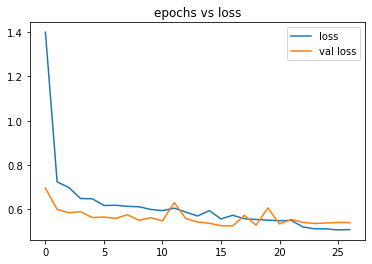

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = history.epoch

plt.plot(epoch,loss, label='loss')
plt.plot(epoch, val_loss, label='val loss')
plt.legend()
plt.title('epochs vs loss')
plt.show()


In [29]:
loss=np.array(loss)
val_loss=np.array(val_loss)
epoch=np.array(epoch)

loss=loss.reshape(loss.shape[0],1)
val_loss=val_loss.reshape(val_loss.shape[0],1)
epoch=epoch.reshape(epoch.shape[0],1)

loss_zong=np.concatenate((epoch,loss,val_loss),axis=1)


print(epoch.shape)
print(val_loss.shape)
print(loss.shape)
print(loss_zong.shape)

data_loss = pd.DataFrame(loss_zong) #将数组转换为dataframe结构
data_loss.columns=['epoch','loss','val_loss']
#writer_loss = pd.ExcelWriter(r'\loss.xls')   # 写入Excel文件

data_loss.to_excel(writer_loss,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_loss.save()
writer_loss.close()

(27, 1)
(27, 1)
(27, 1)
(27, 3)


训练标准差STD= 0.6937908650909117
训练误差均值MEAN= -0.029419058629426835
训练平均绝对误差MAE= 0.5416598892831437
训练RMSE= 0.6944143183246132
训练MAPE= 22.64177081616011
训练r2 score: 0.7393920794848561


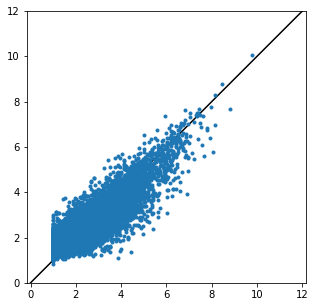

In [29]:
pred_train_all = model.predict([train_xt,train_xs,train_feature]).ravel()


from sklearn import metrics
from sklearn.metrics import r2_score
print("训练标准差STD=",np.std(pred_train_all-train_y.ravel()))
print("训练误差均值MEAN=",np.mean(pred_train_all-train_y.ravel()))
print("训练平均绝对误差MAE=",metrics.mean_absolute_error(pred_train_all, train_y.ravel()))
print("训练RMSE=",metrics.mean_squared_error(pred_train_all, train_y.ravel())**0.5)
print("训练MAPE=",np.mean(np.abs((train_y.ravel() - pred_train_all) / train_y.ravel())) * 100)
print("训练r2 score:", r2_score(train_y.ravel(), pred_train_all))

plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(0, 12, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(train_y.ravel(),pred_train_all,'.')
plt.xlim(0, 12)
plt.ylim(0, 12)
plt.show()

In [31]:
#########################保存训练结果####################################
train_pre=pred_train_all.reshape(pred_train_all.shape[0],1)
tr_result=np.concatenate((train_y,train_pre),axis=1)

print(tr_result.shape)

data_tr = pd.DataFrame(tr_result) #将数组转换为dataframe结构
data_tr.columns=['True-I','Pre-I']
#writer_tr = pd.ExcelWriter(r'\train.xls')   # 写入Excel文件

data_tr.to_excel(writer_tr,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tr.save()
writer_tr.close()




(5676, 2)


测试标准差STD= 0.7345274342387028
测试误差均值MEAN= 0.06934472821704986
测试平均绝对误差MAE= 0.5842596567868157
测试RMSE= 0.7377934961632479
测试MAPE= 26.73553414432524
测试r2 score: 0.7065673338718303


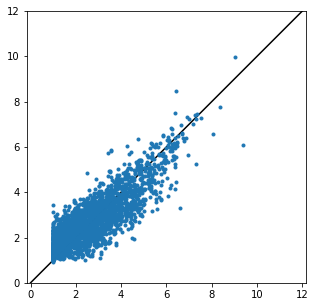

In [30]:
pred_test_all = model.predict([test_xt,test_xs,test_feature]).ravel()  ##ravel() 转换成1列

print("测试标准差STD=",np.std(pred_test_all-test_y.ravel()))
print("测试误差均值MEAN=",np.mean(pred_test_all-test_y.ravel()))
print("测试平均绝对误差MAE=",metrics.mean_absolute_error(pred_test_all, test_y.ravel()))
print("测试RMSE=",metrics.mean_squared_error(pred_test_all, test_y.ravel())**0.5)
print("测试MAPE=",np.mean(np.abs((test_y.ravel() - pred_test_all) / test_y.ravel())) * 100)
print("测试r2 score:", r2_score(test_y.ravel(), pred_test_all))

plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(0, 12, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(test_y.ravel(),pred_test_all,'.')
plt.xlim(0, 12)
plt.ylim(0, 12)
plt.show()   

In [33]:
#########################保存测试结果####################################
test_pre=pred_test_all.reshape(pred_test_all.shape[0],1)
te_result=np.concatenate((test_y,test_pre),axis=1)

print(te_result.shape)

data_te = pd.DataFrame(te_result) #将数组转换为dataframe结构
data_te.columns=['True-I','Pre-I']
#writer_te = pd.ExcelWriter(r'\test.xls')   # 写入Excel文件

data_te.to_excel(writer_te,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_te.save()
writer_te.close()



(2392, 2)


# 2024年6.8级定日地震震例分析

In [31]:
#时域模态信息

import scipy.io as scio
import pandas as pd

#1 input
feature1zl = r'\定日地震\时域\ACC_EW.mat'
data1zl = scio.loadmat(feature1zl)
AAzl=data1zl['ACC_EW']
Azl=AAzl[:,0:300]

feature2zl = r'\定日地震\时域\ACC_NS.mat'
data2zl = scio.loadmat(feature2zl)
BBzl=data2zl['ACC_NS']
Bzl=BBzl[:,0:300]

feature3zl = r'\定日地震\时域\ACC_UD.mat'
data3zl = scio.loadmat(feature3zl)
CCzl=data3zl['ACC_UD']
Czl=CCzl[:,0:300]


raw_data1zl=np.hstack((Azl,Bzl))
x_datazl=np.hstack((raw_data1zl,Czl))

print(x_datazl.shape)



(32, 900)


In [32]:
#频域模态信息

import scipy.io as scio
import pandas as pd

#input
feature1szl = r'\定日地震\频谱\3s\spec_EW_seismic.mat'
data1szl = scio.loadmat(feature1szl)
AAszl=data1szl['spec_EW_seismic']
Aszl=AAszl[:,0:150]

feature2szl = r'\定日地震\频谱\3s\spec_NS_seismic.mat'
data2szl = scio.loadmat(feature2szl)
BBszl=data2szl['spec_NS_seismic']
Bszl=BBszl[:,0:150]

feature3szl = r'\定日地震\频谱\3s\spec_UD_seismic.mat'
data3szl = scio.loadmat(feature3szl)
CCszl=data3szl['spec_UD_seismic']
Cszl=CCszl[:,0:150]





raw_data1szl=np.hstack((Aszl,Bszl))
x_dataszl=np.hstack((raw_data1szl,Cszl))


print(x_dataszl.shape)



(32, 450)


In [33]:
#特征模态信息

import scipy.io as scio
import pandas as pd

labelzl = pd.read_csv(open(r'\定日地震\文本信息\3s\震例文本特征.csv',encoding='UTF-8'))
y_datazl=labelzl.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12]].values  #特征嵌入
print(y_datazl[0])
print(y_datazl.shape)



[-0.81515093 -0.67427834 -0.14052542 -1.27093867 -1.80705182 -0.59734724
  1.75897447  1.21697736  1.59987119 -0.94597893 -0.24290894 -3.56787003
  2.28253444]
(32, 13)


In [34]:
testzl_y=y_datazl[:,[12]]
testzl_feature=y_datazl[:,[0,1,2,3,4,5,6,7,8,9,10,11]]
print(testzl_y.shape)
print(testzl_y[0])

print(testzl_feature.shape)
print(testzl_feature[0])

(32, 1)
[2.28253444]
(32, 12)
[-0.81515093 -0.67427834 -0.14052542 -1.27093867 -1.80705182 -0.59734724
  1.75897447  1.21697736  1.59987119 -0.94597893 -0.24290894 -3.56787003]


In [35]:
#时域模态 测试
testzl_xt=[]
for i in range(len(x_datazl)):
    testzl_xt.append(np.array(x_datazl[i].reshape(3,1,300)).T)

In [36]:
#频域模态 测试
testzl_xs=[]
for i in range(len(x_dataszl)):
    testzl_xs.append(np.array(x_dataszl[i].reshape(3,1,150)).T)

In [37]:
testzl_xt=np.array(testzl_xt)

testzl_xs=np.array(testzl_xs)

In [38]:
#3#  ##Reshaping
#时域
testzl_xt = np.reshape(testzl_xt, (testzl_xt.shape[0], 300, 3))
print("0",testzl_xt.shape[0])
print("1",testzl_xt.shape[1])
print(testzl_xt.shape)

#频域
testzl_xs = np.reshape(testzl_xs, (testzl_xs.shape[0], 150, 3))
print("0",testzl_xs.shape[0])
print("1",testzl_xs.shape[1])
print(testzl_xs.shape)

0 32
1 300
(32, 300, 3)
0 32
1 150
(32, 150, 3)


(150,)


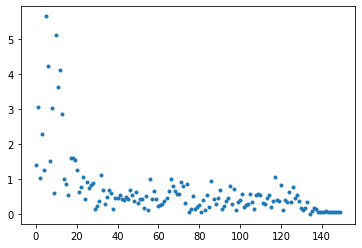

In [39]:
#import matplotlib.pyplot as plt  # 导入图形展示库
plt.plot(testzl_xs[10,:,0],'.')
print(testzl_xs[0,:,0].shape)
#print(test_xs[0,1,:,0].shape)

震例标准差STD= 0.9923312801685994
震例误差均值MEAN= -0.17621173774095533
震例平均绝对误差MAE= 0.7800814432458762
震例RMSE= 1.0078551215917586
震例MAPE= 22.769556225150197
震例r2 score: 0.5392271502153148


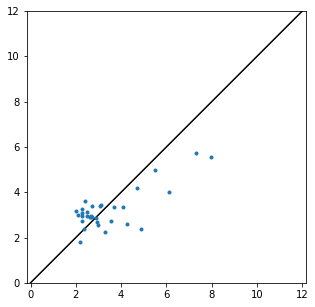

In [40]:
pred_testzl_all = model.predict([testzl_xt,testzl_xs,testzl_feature]).ravel()  ##ravel() 转换成1列

print("震例标准差STD=",np.std(pred_testzl_all-testzl_y.ravel()))
print("震例误差均值MEAN=",np.mean(pred_testzl_all-testzl_y.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_testzl_all, testzl_y.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_testzl_all, testzl_y.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((testzl_y.ravel() - pred_testzl_all) / testzl_y.ravel())) * 100)
print("震例r2 score:", r2_score(testzl_y.ravel(), pred_testzl_all))

plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(0, 12, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(testzl_y.ravel(),pred_testzl_all,'.')
plt.xlim(0, 12)
plt.ylim(0, 12)
plt.show()   

In [41]:
#########################保存测试结果####################################
testzl_pre=pred_testzl_all.reshape(pred_testzl_all.shape[0],1)
tezl_result=np.concatenate((testzl_y,testzl_pre),axis=1)

print(tezl_result.shape)

data_tezl = pd.DataFrame(tezl_result) #将数组转换为dataframe结构
data_tezl.columns=['True-I','Pre-I']
writer_tezl = pd.ExcelWriter(r'\震例.xls')   # 写入Excel文件

data_tezl.to_excel(writer_tezl,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tezl.save()
writer_tezl.close()


(32, 2)
